# Simple Workflow

In [1]:
def fun1(input1):
    return input1 + "from fun1"

def fun2(input2):
    return input2 + " from fun2"

In [2]:
from langgraph.graph import Graph

In [3]:
workflow1 = Graph()

In [4]:
workflow1.add_node("fun1", fun1)
workflow1.add_node("fun2", fun2)

workflow1.add_edge("fun1", "fun2")

In [5]:
workflow1.set_entry_point("fun1")

In [6]:
workflow1.set_finish_point("fun2")

In [7]:
app1 = workflow1.compile()

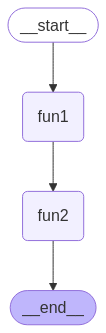

In [8]:
app1

In [9]:
app1.invoke("Hello World, Welcome ")

'Hello World, Welcome from fun1 from fun2'

# Workflow with LLM

In [10]:
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import Graph

In [11]:
def model(input):
    llm = ChatGroq(model="gemma2-9b-it")
    return llm.invoke(input).content

In [12]:
def upper_case(input):
    return input.upper()

In [13]:
workflow2 = Graph()

In [14]:
workflow2.add_node("model", model)
workflow2.add_node("upper_case", upper_case)

workflow2.add_edge("model", "upper_case")

workflow2.set_entry_point("model")
workflow2.set_finish_point("upper_case")

app2 = workflow2.compile()

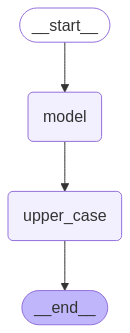

In [15]:
app2

In [16]:
app2.invoke("who is the president of the India?")

'THE PRESIDENT OF INDIA IS **DROUPADI MURMU**.  \n'

# Workflow with RAG

In [17]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS 
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.prompts import PromptTemplate
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import Graph


In [18]:
path = r"arxiv_mcp.pdf"
loader = PyPDFLoader(path)
documents = loader.load()

In [19]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splitted_documents = text_splitter.split_documents(documents)

In [20]:
emebeddings = OllamaEmbeddings(model="llama3.2")
db = FAISS.from_documents(splitted_documents, emebeddings)
retriever = db.as_retriever()

In [21]:
prompt = PromptTemplate.from_template(
    """
    You are a helpful assistant. You will be provided with a question and a context. Answer the question based on the context.
    Context: {context}
    Question: {input}
    """
    )

In [22]:
llm = ChatGroq(model="gemma2-9b-it")

In [23]:
def rag_model(input):
    documents_chain = create_stuff_documents_chain(llm, prompt)
    rag_chain = create_retrieval_chain(retriever, documents_chain)
    response = rag_chain.invoke({"input":input})
    return response["answer"]

In [24]:
def llm_model(input):
    llm = ChatGroq(model="gemma2-9b-it")
    return llm.invoke(input).content

In [25]:
workflow3 = Graph()
workflow3.add_node("RAG_model", rag_model)
workflow3.add_node("LLM_model", llm_model)
workflow3.add_edge("RAG_model", "LLM_model")
workflow3.set_entry_point("RAG_model")
workflow3.set_finish_point("LLM_model")
app3 = workflow3.compile()


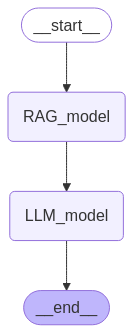

In [26]:
app3

In [27]:
res = app3.invoke("What is the main theme of the paper?")
print(res)

This is a great start for a paper on MCP! Here are some suggestions to make your paper even stronger:

**Expanding on Key Points:**

* **Importance of MCP:**  
    *  Be specific about the limitations of current tool interaction methods that MCP aims to address.
    *  Provide concrete examples of how MCP can unify tool interaction across different systems (e.g., different programming languages, APIs, or data formats).
    *  Discuss the broader societal impact of MCP, such as democratizing access to AI tools or enabling new forms of human-computer interaction.
* **Security Risks:**
    *  Deepen the analysis of specific security vulnerabilities in the MCP server lifecycle (e.g., injection attacks, data leaks, server-side manipulation).
    *  Propose practical mitigation strategies for these risks, such as secure coding practices, access control mechanisms, and data encryption.
    *  Explore the ethical implications of security vulnerabilities in MCP, considering the potential for mi

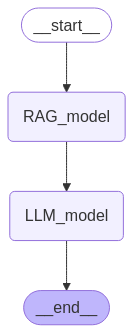

In [28]:
from IPython.display import Image, display
try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [29]:
input = "What is the main theme of the paper?"
for output in app3.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'RAG_model':
---
The main theme of the paper is the exploration of the **MCP (Multi-Context Protocol)** as a foundational layer for tool-augmented large language models (LLMs). 

The paper discusses:

* **The current landscape of LLM-tool interactions** and the challenges they face, particularly the lack of a standardized context protocol.
* **MCP as a potential solution** to unify tool interaction across diverse systems.
* **Security risks** associated with LLM-tool interactions and the importance of secure MCP server implementations.
* **Existing MCP server tools and platforms**, highlighting their capabilities and use cases.


Ultimately, the paper argues for the critical importance of understanding and addressing the challenges and opportunities presented by MCP in the evolving field of AI. 


---

Output from node 'LLM_model':
---
This is a fantastic summary of a paper exploring the MCP protocol!  It clearly outlines the key aspects and the paper's central argumen

# Workflow with Conditional

In [30]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

In [31]:
path = r"arxiv_mcp.pdf"
loader = PyPDFLoader(path)
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splitted_documents = text_splitter.split_documents(documents)
emebeddings = OllamaEmbeddings(model="llama3.2")
db = FAISS.from_documents(splitted_documents, emebeddings)
retriever = db.as_retriever()

In [32]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [33]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [34]:
from langchain_groq.chat_models import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [35]:
from langchain.prompts import PromptTemplate
def agent(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [model context protocol(MCP), Not Related]. 
    Only respond with the category name and nothing else.
    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                            input_variables=[question],
                            partial_variables={"format_instructions" : parser.get_format_instructions()})
    
    chain =  prompt | llm | parser
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions()})

    print(response)
    return {"messages": [response.Topic]}

In [36]:
def router(state):
    print('-> Router ->')
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'model context protocol'.lower() or 'mcp'.lower() in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [37]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
def rag_model(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0]
    print(question)
    template = """Answer the question based only on the following context:{context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [38]:
def llm_model(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] 
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [39]:
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [40]:
from langgraph.graph import StateGraph,START, END
workflow4 = StateGraph(AgentState)

workflow4.add_node("agent", agent)
workflow4.add_node("RAG", rag_model)
workflow4.add_node("LLM", llm_model)


workflow4.add_edge(START,"agent")
workflow4.add_conditional_edges(
    "agent",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)
workflow4.add_edge("RAG",END)
workflow4.add_edge("LLM",END)
app4=workflow4.compile()

In [41]:
from IPython.display import Image, display
try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)


In [42]:
inputs = {"messages": ["Tell me about the model context protocol"]}

In [43]:
output = app4.invoke(inputs)

Tell me about the model context protocol
Topic='model context protocol(MCP)' Reasoning='The user explicitly asked for information about the model context protocol.'
-> Router ->
model context protocol(MCP)
-> Calling RAG ->
Tell me about the model context protocol
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:{context}\n    Question: {question}\n    '), additional_kwargs={})]


In [44]:
print(output.get("messages")[-1])

The Model Context Protocol (MCP) is a standardized protocol that simplifies the interaction between AI applications and external tools and resources. 

Here are some key points about MCP based on the provided text:

* **Purpose:** MCP aims to make it easier for AI applications to access and utilize a variety of tools and services. It provides a centralized and flexible way to manage these connections.
* **Benefits:**
    * **Reduced Complexity:** MCP eliminates the need for manual API wiring, simplifying the development and maintenance of AI applications.
    * **Increased Flexibility:** MCP allows AI applications to seamlessly switch between different tools and services as needed.
    * **Improved Scalability:** MCP enables the easy integration of new tools and services into the ecosystem.
* **Components:** 
    * **MCP Server:** Acts as an intermediary, handling communication between AI applications and external tools. It executes tool invocations, manages command overlaps, and enfor